# Vecchia 3D parameter estimation using maximum likelihood estimation

This example will cover:
 - Using the Vecchia approximation for drawing prior samples, inferring parameters and making predictions
 - Use maximum likelihood estimation to optimise kernel parameters

Code is heavily borrowed from github.com/mingdeyu/DGP

***GPVecchia uses `numba` so it is slow to run the first time.***

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import time

from gpvecchia.vecchia import GPtideVecchia
from gptide import mle

### Generate some 3D data

In [25]:
# Create some data coordinates
np.random.seed(0)

# Number of data points
totp = 10000

# spatial coords
xs = ys = zs = 50
X = np.column_stack((np.random.randint(0, xs, totp),
                     np.random.randint(0, ys, totp),
                     np.random.randint(0, zs, totp))).astype(np.float64)
Xix = np.argsort(X[:,0])
X = X[Xix] # Data would generally come sorted along one dimension - Vecchia will do some re-ordering

print(X.shape)
print(xs*ys*zs)

(10000, 3)
125000


In [26]:
# Example mean func
def my_mean(x, mean):
    return np.ones(x.shape[0]) * mean

from numba import njit

@njit(cache=True)
def matern32_matrix_numba(d,l):
    fac1 = 3*d**2
    fac2 = np.sqrt(fac1)
    return (1 + fac2/l)*np.exp(-fac2/l)

In [27]:
# These are our kernel input parameters
gp_noise = 0.1
gp_std = 0.5
xl = 3
yl = 9
zl = 13

# GPVecchia parameters
n_neighbours = 30 # number of neighbours to use
cov_func = matern32_matrix_numba
cov_params = (gp_std, xl, yl, zl)
mean_func = my_mean
mean_params = 20.0
order_func = np.random.permutation # including a re-ordering function is important
order_params = len(X)
nn_kwargs = {'method':'sklearn'} # this SKLearn KD Tree method was fastest in testing so it is the default, but FAISS might be better on HPC

### Object initialisation

In [28]:
tstart = time.time()

gp_vec = GPtideVecchia(X, 
                       X,
                       gp_noise, 
                       cov_func, 
                       cov_params,
                       mean_func=mean_func, mean_params=mean_params,
                       order_func=order_func, order_params=order_params,
                       nnum=n_neighbours, nn_kwargs=nn_kwargs)

init_time = time.time() - tstart
print(f'Initialisation time: {init_time:.2f} seconds for {totp} points')
print(gp_vec)
print(gp_vec.nn_array.shape)
print(gp_vec.nn_array)

Initialisation time: 0.39 seconds for 10000 points
(10000, 31)
[[   0   -1   -1 ...   -1   -1   -1]
 [   1    0   -1 ...   -1   -1   -1]
 [   2    1    0 ...   -1   -1   -1]
 ...
 [9997 9678 9672 ... 1159 1045   71]
 [9998 9689 9230 ...  923  839  354]
 [9999 9966 9317 ... 1254 1192  357]]


### Draw from the prior

In [29]:
n_samp = 1

tstart = time.time()
smp_prior = gp_vec.sample_prior(samples=n_samp, add_noise=True)
sp_time = time.time() - tstart

print(f'Prior sampled in {sp_time:.2f} seconds')
print(smp_prior.shape)

Prior sampled in 4.83 seconds
(10000,)


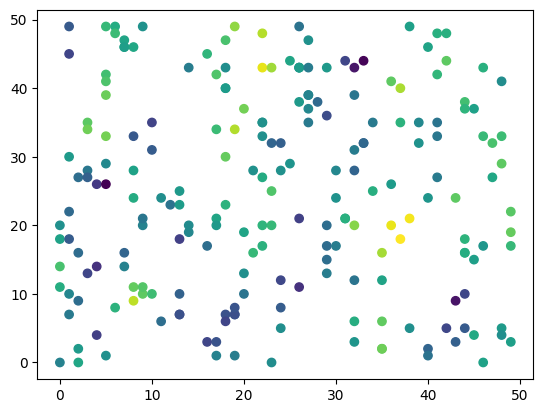

In [30]:
idx = X[:,-1] == 0
plt.scatter(X[:,0][idx], X[:,1][idx], c=smp_prior[idx], cmap='viridis')

### Evaluate the log-likelihood
Just using the true parameters here.

In [31]:
# Make one of the prior samples the input observations
y = smp_prior

sm_std = np.std(y - np.mean(y))
print(f'Small scale std dev.: {sm_std:.4}')
print(f'Mean: {np.mean(y):.4}')

tstart = time.time()
loglike = gp_vec.log_marg_likelihood(y)
ll_time = time.time() - tstart
print(f'Log likelihood computed in {ll_time:.3f} seconds')
print(loglike)

Small scale std dev.: 0.4536
Mean: 19.91
Log likelihood computed in 7.318 seconds
[16501.45504313]


## MLE 

Try to infer the hyperparameters using maximum likelihood estimation. 

Will set the tolerance high because log-likelihood is a large number.

Didn't have much luck with gradient based methods, but there is an analytical form for the log-likelihood gradient which Ming has implemented (we could add).

In [32]:
# Initial guess of the noise and covariance parameters (these can matter)
noise_ic = 0.05
covparams_ic = [0.4, 5., 5., 16.]
meanparams_ic = [18.]

soln = mle(
    X,
    y,
    cov_func,
    covparams_ic,
    noise_ic,
    meanfunc=mean_func,
    meanparams_ic=meanparams_ic,
    method='Nelder-Mead',
    GPclass=GPtideVecchia,
    gp_kwargs={'order_func':order_func, 'order_params':order_params, 'nn_kwargs':nn_kwargs},
    bounds=None,
    verbose=False)


print('Noise (true): {:3.4f}, |Noise| (mle): {:3.4f}'.format(gp_noise, soln['x'][0]))
print('η (true): {:3.3f}, η (mle): {:3.3f}'.format(sm_std, soln['x'][1]))
print('ℓx (true): {:3.2f}, ℓx (mle): {:3.2f}'.format(cov_params[1], soln['x'][2]))
print('ℓy (true): {:3.2f}, ℓy (mle): {:3.2f}'.format(cov_params[2], soln['x'][3]))
print('ℓt (true): {:3.2f}, ℓt (mle): {:3.2f}'.format(cov_params[3], soln['x'][4]))
print('mean (true): {:3.2f}, mean (mle): {:3.2f}'.format(np.mean(y), soln['x'][5]))

Noise (true): 0.1000, |Noise| (mle): 0.0684
η (true): 0.454, η (mle): 0.508
ℓx (true): 3.00, ℓx (mle): 2.77
ℓy (true): 9.00, ℓy (mle): 6.58
ℓt (true): 13.00, ℓt (mle): 10.95
mean (true): 19.91, mean (mle): 20.10


### Evaluating the likelihood gradient

***Not implemented yet***

## Conditioning on data

Mean and variance predictions 

In [33]:
x_pred = np.linspace(0, xs, 50)
y_pred = np.linspace(0, ys, 50)
z_pred = np.linspace(0, zs, 20)

# Prediction points dont need to be randomly ordered
xx_grid, yy_grid, zz_grid = np.meshgrid(x_pred, y_pred, z_pred, indexing='ij')
X_pred = np.column_stack((xx_grid.ravel(), yy_grid.ravel(), zz_grid.ravel())).astype(np.float64)
print(X_pred.shape)

(50000, 3)


In [34]:
gp_vec = GPtideVecchia(X, 
                       X_pred,
                       gp_noise, 
                       cov_func, 
                       cov_params,
                       mean_func=mean_func, mean_params=mean_params,
                       order_func=order_func, order_params=order_params,
                       nnum=n_neighbours, nn_kwargs=nn_kwargs)

tstart = time.time()
y_mean, y_uq = gp_vec(y)
cnd_time = time.time() - tstart

print(f'Conditioning completed in {cnd_time:.2f} seconds')
print(y_mean.shape)
print('Pred variance:', np.var(y_mean - np.mean(y_mean)))
print(y_uq.shape)

Conditioning completed in 6.16 seconds
(50000,)
Pred variance: 0.1935583606809763
(50000,)


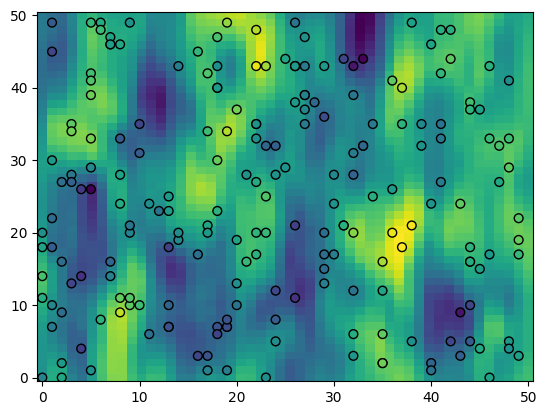

In [35]:
plt.pcolormesh(xx_grid[:,:,0], yy_grid[:,:,0], y_mean.reshape(xx_grid.shape)[:,:,0], cmap='viridis')

idx = X[:,-1] == 0
plt.scatter(X[:,0][idx], X[:,1][idx], c=y[idx], cmap='viridis', ec='k', s=40)

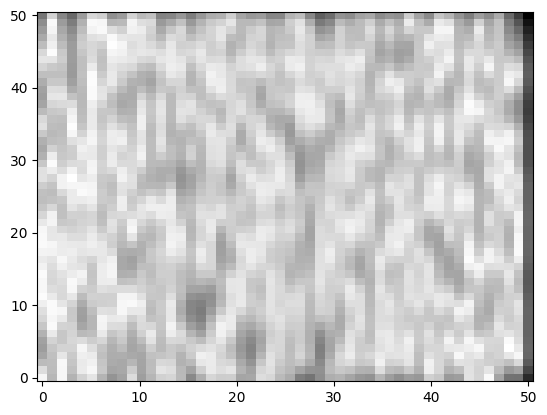

In [36]:
plt.pcolormesh(xx_grid[:,:,0], yy_grid[:,:,0], y_uq.reshape(xx_grid.shape)[:,:,0], cmap='gray_r')

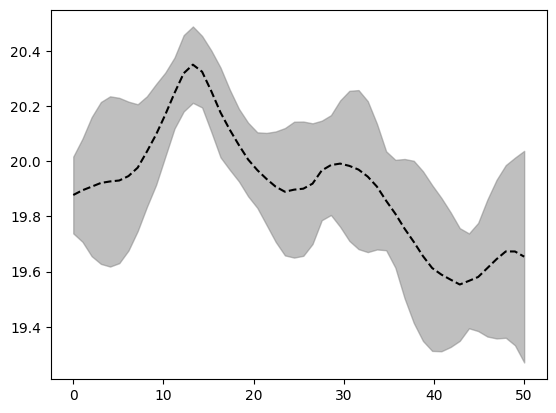

In [37]:
plt.plot(xx_grid[:,0,0], y_mean.reshape(xx_grid.shape)[0,:,0], 'k--')
plt.fill_between(xx_grid[:,0,0],
                 y_mean.reshape(xx_grid.shape)[0,:,0] - 2*y_uq.reshape(xx_grid.shape)[0,:,0],\
                 y_mean.reshape(xx_grid.shape)[0,:,0] + 2*y_uq.reshape(xx_grid.shape)[0,:,0],\
                 color='gray', alpha=0.5)